# Scraping Data Jobs with Python and Selenium

As a data professional, I am always on the hunt for exciting new opportunities. 

I wanted to build a simple webscraper to pu

FIXME: The Indeed scraper is having trouble with company names

I am on the west coast, and I'd like to get a data scientist job, let's highlight these things in our data...

### NOTES
1) cool [post](https://towardsdatascience.com/gone-to-find-myself-finding-where-i-am-in-the-data-science-world-by-web-scraping-job-postings-bf416dbfb6fa) about this! 
2) Another cool [post](https://towardsdatascience.com/web-scraping-indeed-com-e5591790736d) more stats/ML based
3) Start super simple and then build your way up. Post a medium article to get something out there!
4) Do a Selenium and Beautiful Soup Version
5) Scrape data, visualize data. 
6) more reading and examples: https://towardsdatascience.com/the-most-in-demand-skills-for-data-scientists-in-2021-4b2a808f4005
7) more reading and examples:https://medium.com/@alex.kirkup/web-scraping-2023-data-science-jobs-listings-to-extract-the-key-skills-required-2359bfab176e

TODO: Markdown

TODO: Docstrings and comments

TODO: move wordcloud mask to repo dir

TODO: Clean up plots

TODO: Add job salary viz


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import matplotlib
from wordcloud import WordCloud
from PIL import Image
import geopandas as gpd
from shapely.geometry import Polygon

import regex as re

from lists_and_dicts import *
from JobScraper import DataJobsScraper, clean_title, get_state_code, PATH

# some colors I'll be using
gr = sns.color_palette('Greens_d').as_hex()[0]
bl = sns.color_palette('Blues_d').as_hex()[2]
lgrey = '#AEAEAE'
dgrey = '#4f4e4e'
bg_color = '#FFFFFF'

# just setting up some default formatting params
default_font_size = 18
default_font_color = dgrey
default_font_alignment = 'left'
default_font_kwargs = {'color':default_font_color, 'fontsize':default_font_size, 'horizontalalignment':default_font_alignment}

# sns.set_style(style="darkgrid")

### Analysis

In [2]:
scrape_data = False
if scrape_data:

    djs = DataJobsScraper(site='Indeed')
    djs.scrape_jobs()
    djs.scrape_job_text()
    djs.clean_data()
    djs.export_data(data_path=PATH)

# note: we should separate out the 04/01/2024 indeed pulls from just CA and WA
# TODO: be smarter about this merge
indeed_job_meta = pd.read_csv(PATH + "/Indeed_job-meta.csv", delimiter=',')
indeed_job_descriptions = pd.read_csv(PATH + "/Indeed_job-descriptions.csv", delimiter=',')
dj_job_meta = pd.read_csv(PATH + "/DataJobs_job-meta.csv", delimiter=',')
dj_job_descriptions = pd.read_csv(PATH + "/DataJobs_job-descriptions.csv", delimiter=',')

In [3]:
job_meta = pd.concat([
    indeed_job_meta,
    dj_job_meta
], ignore_index=True)

job_descriptions = pd.concat([
    indeed_job_descriptions.merge(indeed_job_meta[['job_id', 'site']], on='job_id', how='left'),
    dj_job_descriptions.merge(dj_job_meta[['job_id', 'site']], on='job_id', how='left')
], ignore_index=True)

# old datajobs entries didn't have this
job_descriptions['site'].fillna('https://datajobs.com/',inplace=True)

### some styling options

1) https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08


<>:50: SyntaxWarning: invalid escape sequence '\ '
<>:56: SyntaxWarning: invalid escape sequence '\ '
<>:64: SyntaxWarning: invalid escape sequence '\ '
<>:50: SyntaxWarning: invalid escape sequence '\ '
<>:56: SyntaxWarning: invalid escape sequence '\ '
<>:64: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_26324/3115030876.py:50: SyntaxWarning: invalid escape sequence '\ '
  labels[idx] = '$\\mathbf{Data\ Scientist}$'
/tmp/ipykernel_26324/3115030876.py:56: SyntaxWarning: invalid escape sequence '\ '
  ds_idx = labels.index('$\\mathbf{Data\ Scientist}$')
/tmp/ipykernel_26324/3115030876.py:64: SyntaxWarning: invalid escape sequence '\ '
  emph_positions = ['Data\ Scientist']
/tmp/ipykernel_26324/3115030876.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels = labels)


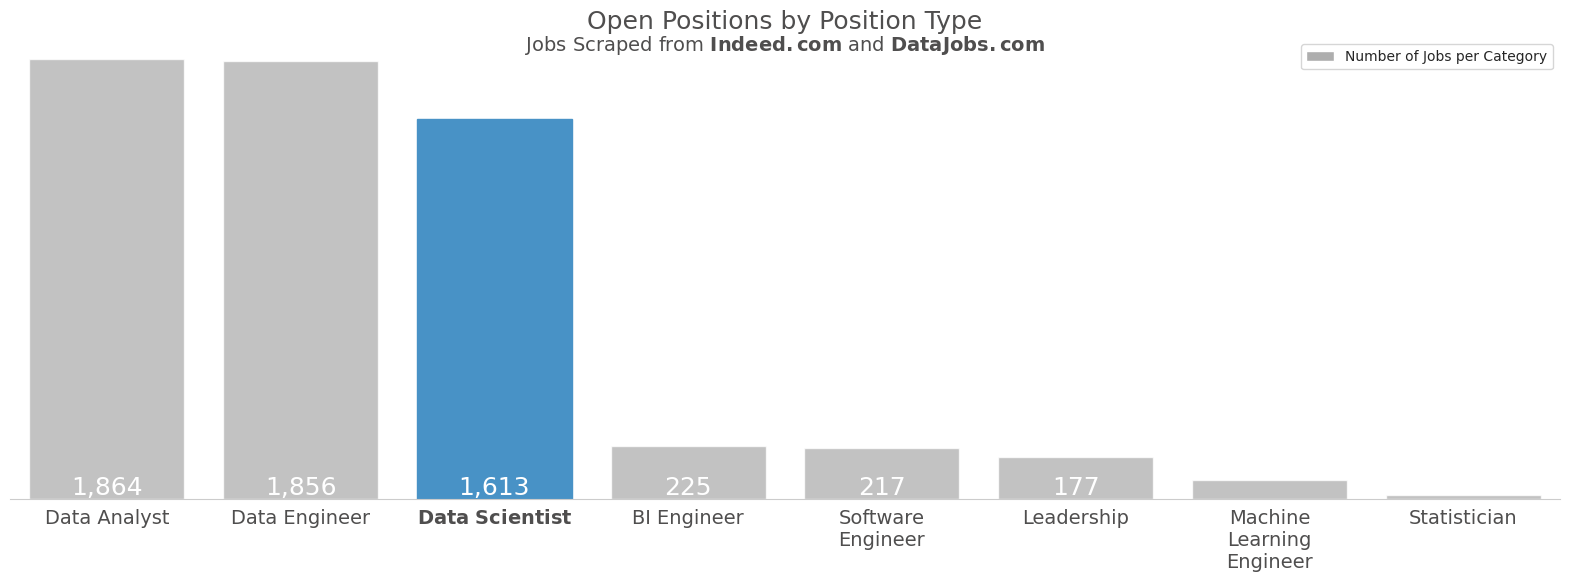

In [4]:
sns.set_style("whitegrid")
# when you're ready to export uncomment this for a sharper image
# plt.rcParams['figure.dpi'] = 360

f, ax = plt.subplots(figsize=(20,6))
# there are a lot of duplicates accross the categories
clean_title_counts = job_meta['clean_title'].value_counts().reset_index()

# Plot the cats
sns.barplot(x='clean_title', y="count", data=clean_title_counts[clean_title_counts['count'] > 1].head(8),
            label="Number of Jobs per Category", color = lgrey, ax = ax)
sns.despine(left=True)
# ax.bar_label(ax.containers[0]);

# label the bars with counts
dlabel_kwargs = default_font_kwargs.copy()
dlabel_kwargs['horizontalalignment'] = 'center'
dlabel_kwargs['color'] = bg_color
for idx, lbl in enumerate(list(ax.containers[0])):
    h = int(lbl.get_height())
    if h >100:
        plt.text(x=idx, y=20, s=f"{int(lbl.get_height()):,}", **dlabel_kwargs)


# ax.set_ylabel('Number of Positions', size=18, color='#4f4e4e');
ax.set_ylabel('');
ax.set_xlabel('');
title_kwargs = default_font_kwargs.copy()
title_kwargs['horizontalalignment'] = 'center'
ax.set_title(f'Open Positions by Position Type', **title_kwargs);
subtitle_kwargs = default_font_kwargs.copy()
subtitle_kwargs['horizontalalignment'] = 'center'
subtitle_kwargs['fontsize'] = 14
plt.text(x=3.5, y=1900, s='Jobs Scraped from $\\bf{Indeed.com}$ and $\\bf{DataJobs.com}$', **subtitle_kwargs)

plt.xticks(size=14, color=default_font_kwargs['color']);
# plt.yticks(size=14, color='#4f4e4e');
plt.yticks([],[]);

# there is a weird warning with escaping the space in the data scientist position
# however, escaping is the only way to get the space to show up in the LaTeX. 
# so I just filter out all warnings for this section so I don't have to look at it.

# let's fix the MLE text
labels = [item.get_text() for item in ax.get_xticklabels()]
for idx, label in enumerate(labels):
    if len(label) > 14:
        labels[idx] = '\n'.join(label.split())
    elif label == 'Data Scientist':
        labels[idx] = '$\\mathbf{Data\ Scientist}$'

ax.set_xticklabels(labels = labels)


# let's highlight the data scientist positions
ds_idx = labels.index('$\\mathbf{Data\ Scientist}$')
# now we can get this specific bar
childrenLS=ax.get_children()
barlist=list(filter(lambda x: isinstance(x, matplotlib.patches.Rectangle), childrenLS))
# and set the color to blue!!!
barlist[ds_idx].set_color(sns.color_palette('Blues_d').as_hex()[2])

# let's highlight the postitions we care about
emph_positions = ['Data\ Scientist']
emph_idx = [labels.index('$\\mathbf{' + pos + '}$') for pos in emph_positions]

childrenLS=ax.get_children()
barlist=list(filter(lambda x: isinstance(x, matplotlib.patches.Rectangle), childrenLS))

for idx, bar in enumerate(barlist):
    if idx not in emph_idx:
        bar.set(alpha=0.75)
    else:
        bar.set_color(sns.color_palette('Blues_d').as_hex()[2])

plt.savefig('FIGS/position_types.png');

### Visualize the Number of Jobs in each State
The simplest way to visualize this data is to just grab a bar chart. Bar charts are the single most versatile data visualization you can possibly use. They have so many benefits and everyone overlooks them because they're "boring". I argue, and so does Coole Nussbaumer Knaflic in her book **storytelling with data** that it is _because_ they are boring is what makes them so useful! Everyone (and I mean everyone) knows what a bar chart is. Thus, your meaning is never lost on your audience. They will never have to decifer what a chart is telling them.

/tmp/ipykernel_26324/965387236.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels = labels)


hi


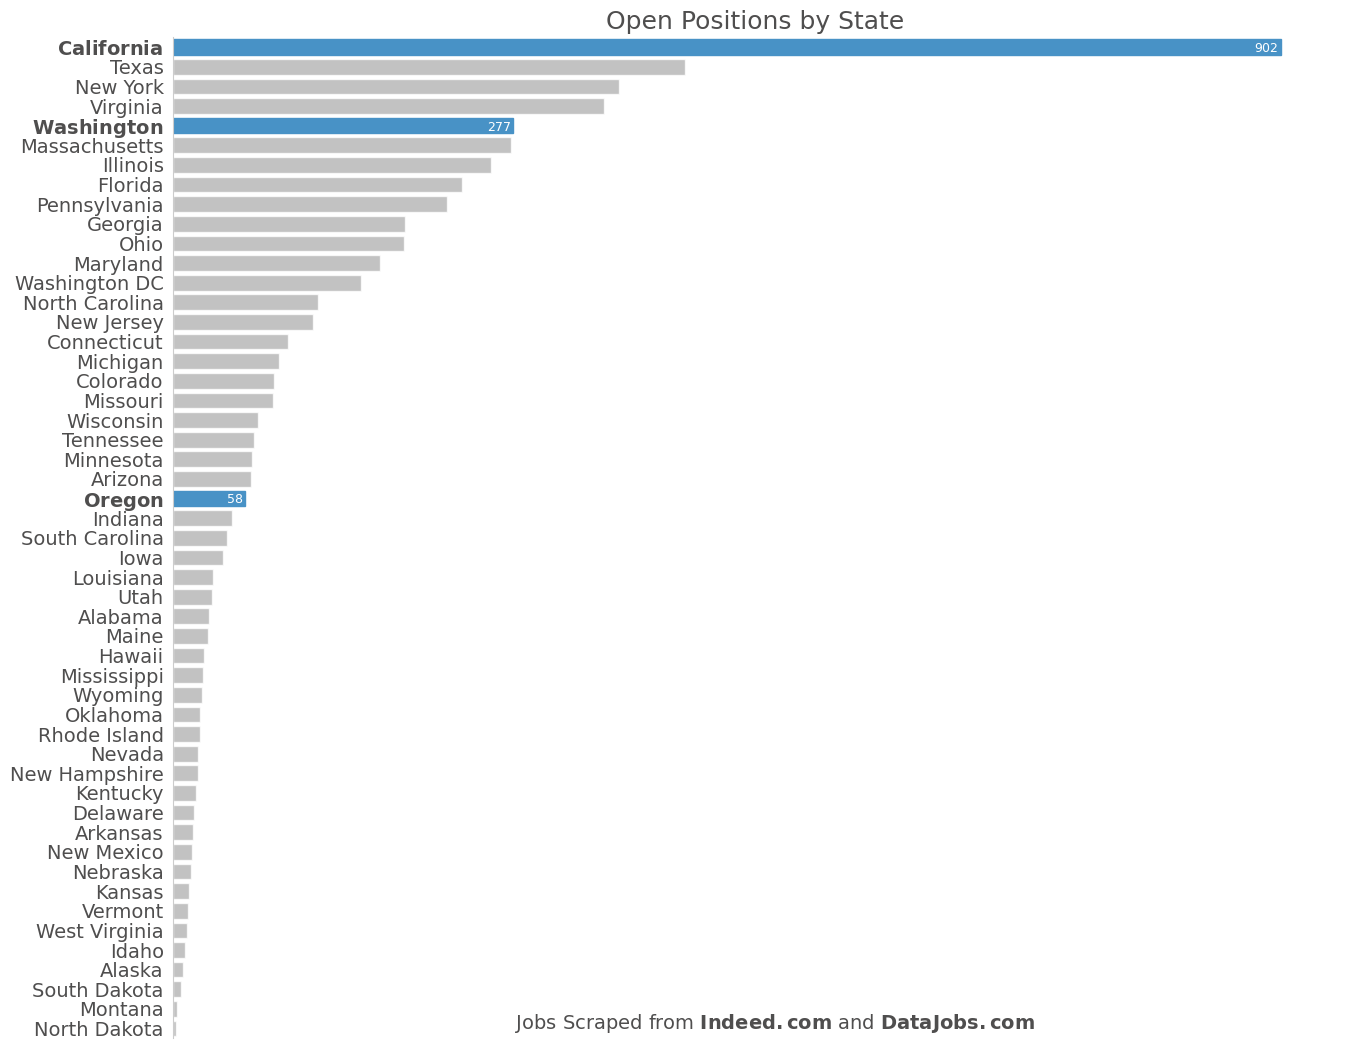

In [5]:
f, ax = plt.subplots(figsize=(15,13))
# just sum up the number of jobs per state (remember that ~10% of jobs state could not be parsed)
num_states = job_meta[job_meta['state'].isin(state_codes)]['state'].value_counts().reset_index().sort_values(by="count", ascending=False).rename({'count':'job_count'}, axis=1)
# I'd rather see the actual name of the state rather than just the abbreviated state code
num_states['state_name'] = num_states['state'].apply(lambda x: state_map[x])

# plot the data
sns.barplot(y='state_name', x="job_count", data=num_states, color=lgrey, ax = ax, orient='h')
# minimalism is your friend
sns.despine(bottom=True)

ax.set_ylabel('')
ax.set_xlabel('');

ax.set_title(f'Open Positions by State', **title_kwargs);
plt.text(x=490, y=50, s='Jobs Scraped from $\\bf{Indeed.com}$ and $\\bf{DataJobs.com}$', **subtitle_kwargs)
plt.yticks(size=14, color=default_font_kwargs['color']);
# plt.yticks(size=14, color='#4f4e4e');
plt.xticks([],[]);

west_cost = ('California', 'Oregon', 'Washington')
# let's signle out the west coast
labels = [item.get_text() for item in ax.get_yticklabels()]
for idx, label in enumerate(labels):
    if label in west_cost:
        labels[idx] = '$\\mathbf{' + label + '}$'

ax.set_yticklabels(labels = labels)


# let's highlight the west coast states
emph_idx = [labels.index('$\\mathbf{' + st + '}$') for st in west_cost]

childrenLS=ax.get_children()
barlist=list(filter(lambda x: isinstance(x, matplotlib.patches.Rectangle), childrenLS))

for idx, bar in enumerate(barlist):
    if idx not in emph_idx:
        bar.set(alpha=0.75)
    else:
        bar.set_color(bl)


dlabel_kwargs['fontsize'] = 9
for idx, lbl in enumerate(list(ax.containers[0])):
    h = int(lbl.get_width())
    if idx in emph_idx and h >= 100:
        plt.text(y=idx+0.25, x=int(h)-12, s=f"{int(h):,}", **dlabel_kwargs)
    elif idx in emph_idx and h < 100:
        print('hi')
        plt.text(y=idx+0.25, x=int(h)-8, s=f"{int(h):,}", **dlabel_kwargs)

plt.savefig('FIGS/position_states.png');

In [6]:
gdf1 = gpd.read_file('./SHAPES/cb_2018_us_state_500k')
gdf = gdf1.merge(num_states,left_on='STUSPS',right_on='state', how='left')
gdf.job_count.fillna(0, inplace=True)
# gdf.to_crs({'init':'epsg:2163'})
gdf = gdf[gdf.STUSPS.isin(state_codes)]

# Apply this to the gdf to ensure all states are assigned colors by the same func
def makeColorColumn(gdf,variable,vmin,vmax):
    # apply a function to a column to create a new column of assigned colors & return full frame
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Blues)
    gdf['value_determined_color'] = gdf[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return gdf


/home/colin/miniconda3/envs/wellfound/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_26324/2998337538.py:80: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  hawaii_gdf.clip(hipolygon).plot(column=variable, color=hawaii_gdf['value_determined_color'].values[0], linewidth=0.8,ax=hiax, edgecolor='0.8')


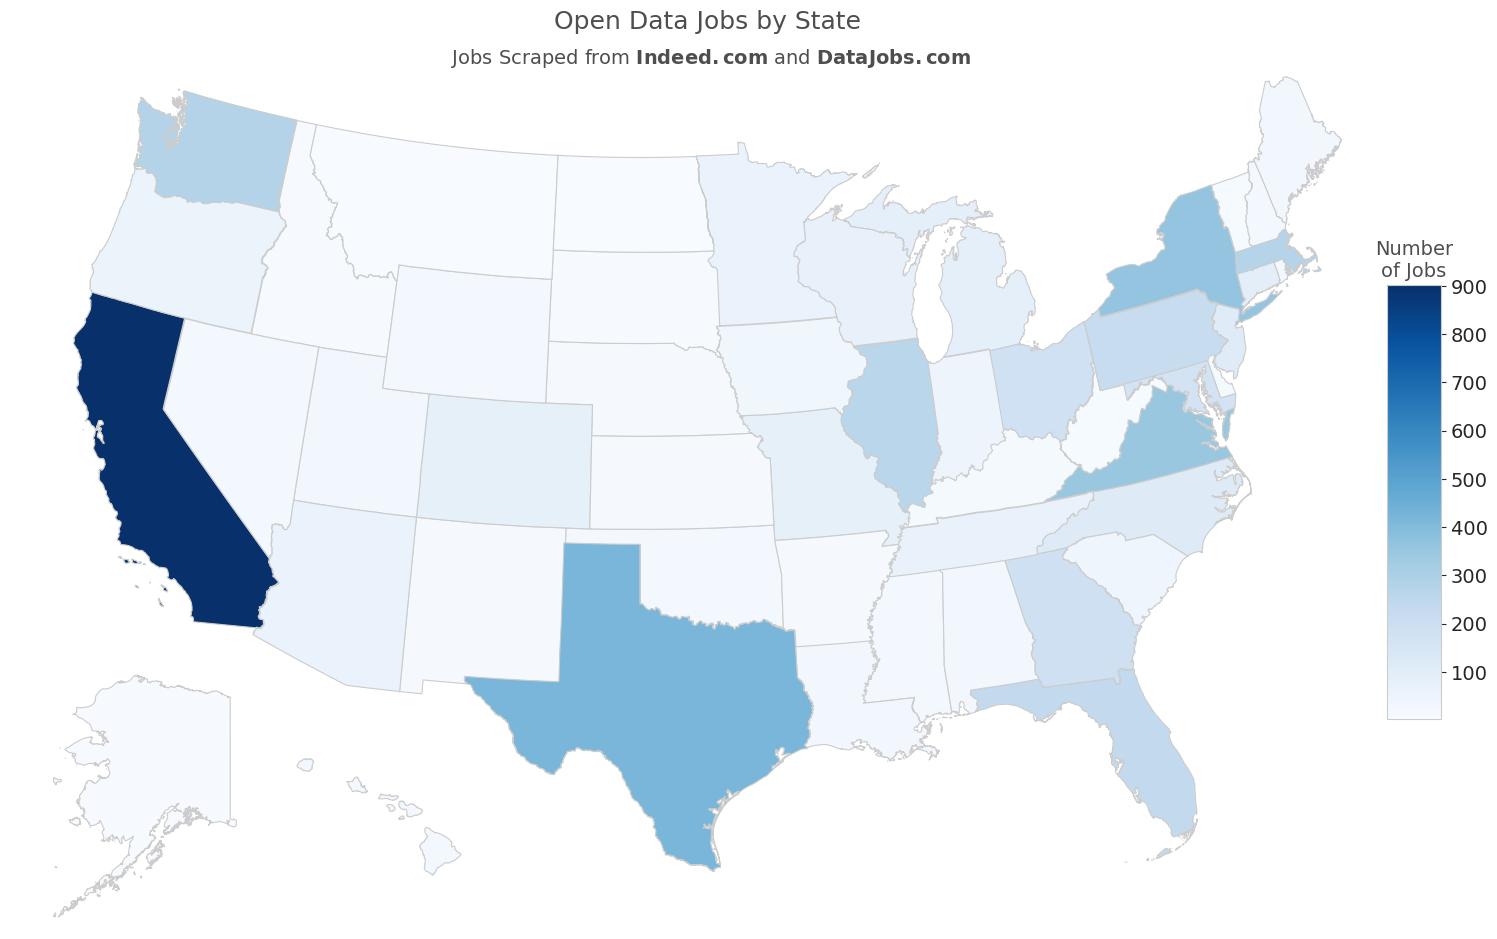

In [7]:
# **************************
# set the value column that will be visualised
variable = 'job_count'
state_var = 'STUSPS'

# make a column for value_determined_color in gdf
# set the range for the choropleth values with the upper bound the rounded up maximum value
vmin, vmax = gdf[variable].min(), gdf[variable].max() #math.ceil(gdf.pct_food_insecure.max())
# Choose the continuous colorscale "YlOrBr" from https://matplotlib.org/stable/tutorials/colors/colormaps.html
colormap = "Blues"
gdf = makeColorColumn(gdf,variable,vmin,vmax)

# create "visframe" as a re-projected gdf using EPSG 2163 for CONUS
visframe = gdf.to_crs({'init':'epsg:2163'})



# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(18, 14))
# remove the axis box around the vis
ax.axis('off')

# add a title and annotation
ax.set_title('Open Data Jobs by State', **title_kwargs);
ax.annotate('Jobs Scraped from $\\bf{Indeed.com}$ and $\\bf{DataJobs.com}$', xy = (0.395,0.625) , xycoords='figure fraction',**subtitle_kwargs)


fig = ax.get_figure()
# add colorbar axes to the figure
# This will take some iterating to get it where you want it [l,b,w,h] right
# l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
cbax = fig.add_axes([0.89, 0.32, 0.03, 0.31])   

cbax.set_title('Number\nof Jobs', **subtitle_kwargs)

# add color scale
sm = plt.cm.ScalarMappable(cmap=colormap, \
                 norm=plt.Normalize(vmin=vmin, vmax=vmax))
# reformat tick labels on legend
sm._A = []
# comma_fmt = FuncFormatter(lambda x, p: format(x/100, '.0%'))
fig.colorbar(sm, cax=cbax)
tick_font_size = 14
cbax.tick_params(labelsize=tick_font_size)

# annotate the data source, date of access, and hyperlink
# ax.annotate("Data: Scraped from https://datajobs.com/", xy=(0.22, .085), xycoords='figure fraction', fontsize=14, color='#555555')


# create map
# Note: we're going state by state here because of unusual coloring behavior when trying to plot the entire dataframe using the "value_determined_color" column
for idx, row in visframe.iterrows():

    if row[state_var] not in ['AK','HI']:
        try:
            vf = visframe[visframe[state_var]==row[state_var]]
            c = gdf[gdf[state_var]==row[state_var]][0:1].value_determined_color.item()
        except:
            print(vf, gdf[gdf[state_var]==row[state_var]][0:1][['STUSPS', 'value_determined_color']], sep='\n'*2) 
        else:
            vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')



#add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
# polygon to clip western islands
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = gdf[gdf[state_var]=='AK']
alaska_gdf.clip(polygon).plot(color=gdf[gdf[state_var]=='AK'].value_determined_color, linewidth=0.8,ax=akax, edgecolor='0.8')


# add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_gdf = gdf[gdf[state_var]=='HI']
hawaii_gdf.clip(hipolygon).plot(column=variable, color=hawaii_gdf['value_determined_color'].values[0], linewidth=0.8,ax=hiax, edgecolor='0.8')

plt.savefig('FIGS/position_density_chloropleth.png');

In [8]:
# Finally, just some nice text!!!

In [9]:
def kw_counter(text, kws):
    kws_counts = {}
    for kw in kws:
        kws_counts[kw] = 0
        if kw == 'Scikit-learn':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' scikitlearn ')
            kws_counts[kw] += text.lower().count(' scikit learn ')
            kws_counts[kw] += text.lower().count(' sci kit learn ')
        elif kw == 'PowerBI':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' Power-BI ')
            kws_counts[kw] += text.lower().count(' Power BI ')
        elif kw == 'Time-Series':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' time series ')
        elif kw == 'A/B Testing':
            # kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' a/b test')
            kws_counts[kw] += text.lower().count(' ab test')
            kws_counts[kw] += text.lower().count(' a-b test')
        elif kw == 'GCP':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' google cloud ')
        elif kw == 'AWS':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' amazon web services ')
        elif kw == 'Webscraping':
            # kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' webscrap')
            kws_counts[kw] += text.lower().count(' web scrap ')
        elif kw =='CNN':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' convolutional neural network ')
        elif kw == 'ANN':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' artificial neural network ')
        elif kw == 'RNN':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' recurrent neural network ')
        elif kw == 'LSTM':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' long-term short-term memory ')
            kws_counts[kw] += text.lower().count(' long term short term memory ')
        elif kw == 'Semi-Supervised Learning':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' semi supervised learning ')
        elif kw == 'Forecasting':
            # kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' forecast')
        elif kw == 'Presentation':
            # kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' present')
        elif kw == 'Communication':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' communicate ')
        elif kw == 'Collaboration':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' collaborate ')
        elif kw == 'Adaptability':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' adapt ')
            kws_counts[kw] += text.lower().count(' adaptable ')
        elif kw == 'Independence':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' independent ')
        elif kw == 'Creativity':
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
            kws_counts[kw] += text.lower().count(' creative ')
        else:
            kws_counts[kw] += text.lower().count(' ' + kw.lower() + ' ')
    
    return kws_counts

In [10]:
buzz_words = programming_languages + libraries + dev_tools + viz_tools + databases + soft_skills + concepts
job_descs_concat = job_descriptions['desc'].str.cat(sep=' ')
all_counts = kw_counter(text = job_descs_concat, kws = buzz_words)
keys = list(all_counts.keys())
values = list(all_counts.values())
sorted_value_index = np.argsort(values)[::-1]
all_counts_sort = {keys[i]: values[i] for i in sorted_value_index}


In [11]:
# TODO: it would be nice to be able to code the color on the 'soft skills' text below

<>:54: SyntaxWarning: invalid escape sequence '\ '
<>:54: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_26324/3869798019.py:54: SyntaxWarning: invalid escape sequence '\ '
  labels[idx] = lbl_str.replace(' ', '\ ')
/tmp/ipykernel_26324/3869798019.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels = labels, color=subtitle_kwargs['color'], fontsize=subtitle_kwargs['fontsize'] );


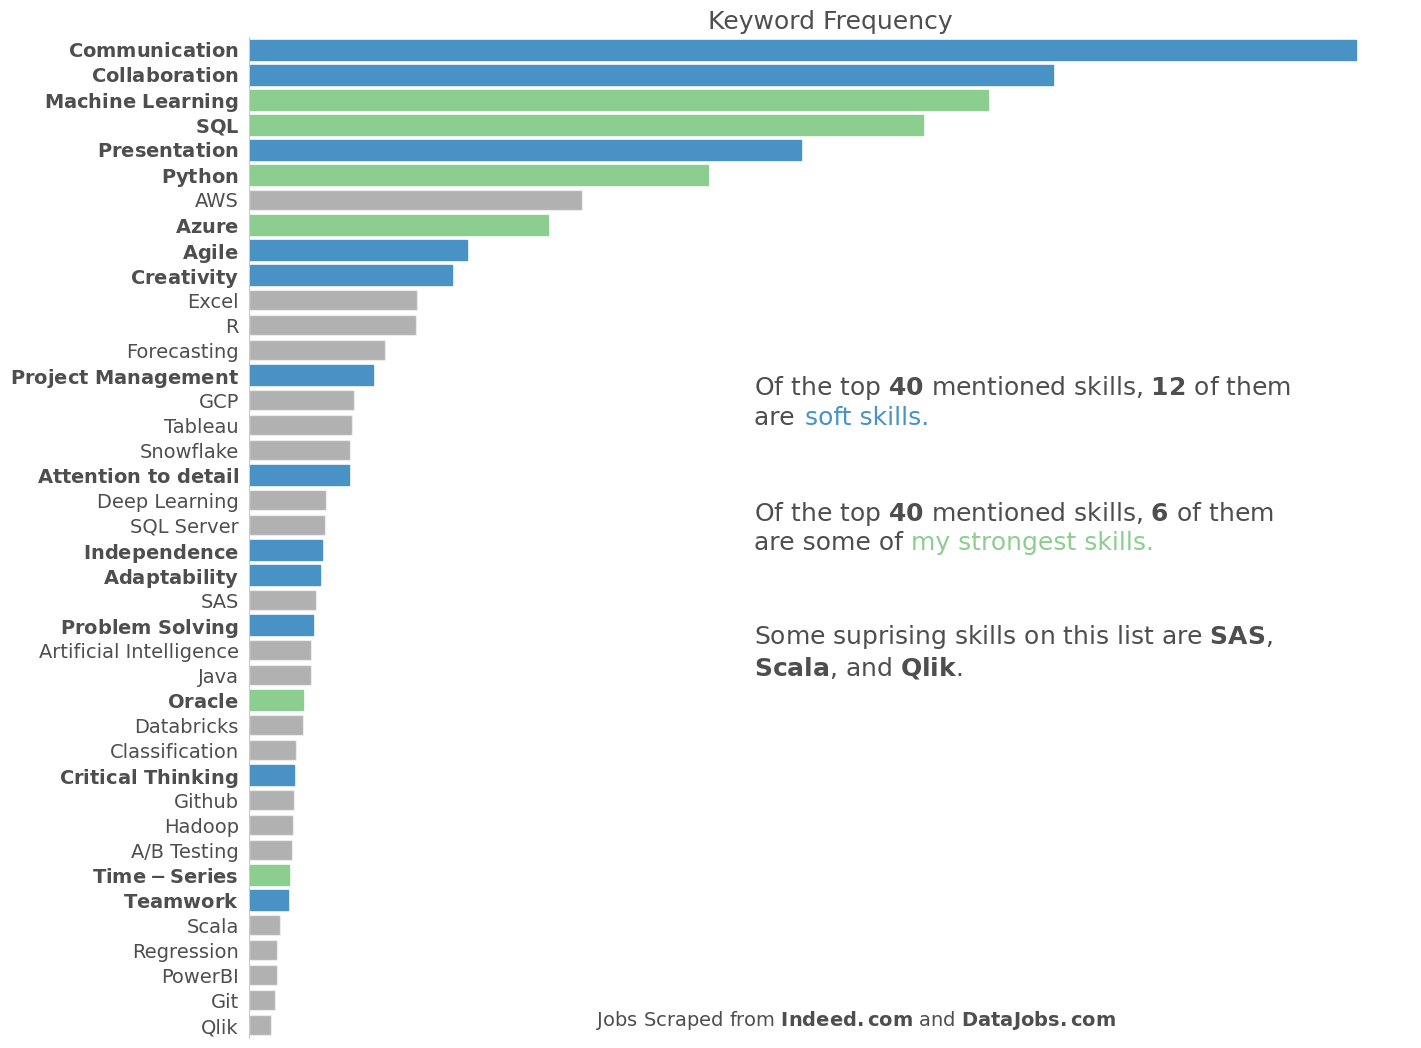

In [12]:
# Plot the crashes where alcohol was involved
from itertools import islice



def take(n, iterable):
    """Return the first n items of the iterable as a list."""
    return dict(islice(iterable, n))

viz_counts = take(n = 40, iterable = all_counts_sort.items())

f, ax = plt.subplots(figsize=(15,13))


sns.set_color_codes("muted")
sns.barplot(y=list(viz_counts.keys()), x=list(viz_counts.values()), color='#656565', ax=ax, orient='h')
# minimalism is your friend
sns.despine(bottom=True)

ax.set_title(f'Keyword Frequency', **title_kwargs);

plt.text(x=3000, y=39, s='Jobs Scraped from $\\bf{Indeed.com}$ and $\\bf{DataJobs.com}$', **subtitle_kwargs)

pos_text_x = 2500
pos_text_y = 15
plt.text(x=pos_text_x, y=pos_text_y, s='Of the top $\\bf{40}$ mentioned skills, $\\bf{12}$ of them \nare ', **default_font_kwargs)
bl_kwargs = default_font_kwargs.copy()
bl_kwargs['color'] = bl
plt.text(x=pos_text_x + 250, y=pos_text_y + 0.001, s=r'soft skills.', **bl_kwargs)

pos_text_x = 2500
pos_text_y = 20
plt.text(x=pos_text_x, y=pos_text_y, s='Of the top $\\bf{40}$ mentioned skills, $\\bf{6}$ of them \nare some of ', **default_font_kwargs)
gr_kwargs = default_font_kwargs.copy()
gr_kwargs['color'] = gr
plt.text(x=pos_text_x + 775, y=pos_text_y + 0.001, s=r'my strongest skills.', **gr_kwargs)

pos_text_x = 2500
pos_text_y = 25
plt.text(x=pos_text_x, y=pos_text_y, s='Some suprising skills on this list are $\\bf{SAS}$, \n$\\bf{Scala}$, and $\\bf{Qlik}$.', **default_font_kwargs)

plt.yticks(size=14, color=default_font_kwargs['color']);
# plt.yticks(size=14, color='#4f4e4e');
plt.xticks([],[]);

# let's signle out the soft skills & my skills
my_skills = ['Python', 'SQL', 'Machine Learning', 'Time-Series', 'Azure', 'Oracle']
labels = [item.get_text() for item in ax.get_yticklabels()]
emph_idx_ss = []
emph_idx_ms = []
for idx, label in enumerate(labels):
    if label in soft_skills + my_skills:
        lbl_str = '$\\mathbf{' + label + '}$'
        labels[idx] = lbl_str.replace(' ', '\ ')
        if label in soft_skills:
            emph_idx_ss.append(idx)
        else:
            emph_idx_ms.append(idx)

ax.set_yticklabels(labels = labels, color=subtitle_kwargs['color'], fontsize=subtitle_kwargs['fontsize'] );

# let's highlight the west coast states
# emph_idx_ss = [labels.index(('$\\mathbf{' + s + '}$').replace(' ', '\ ')) for s in soft_skills]
# emph_idx_ms = [labels.index(('$\\mathbf{' + s + '}$').replace(' ', '\ ')) for s in my_skills]

childrenLS=ax.get_children()
barlist=list(filter(lambda x: isinstance(x, matplotlib.patches.Rectangle), childrenLS))

for idx, bar in enumerate(barlist):
    if idx not in emph_idx_ss and idx not in emph_idx_ms:
        bar.set(alpha=0.5)
    elif idx in emph_idx_ss:
        bar.set_color(bl)
    elif idx in emph_idx_ms:
        bar.set_color(gr)

# for idx, lbl in enumerate(list(ax.containers[0])):
#     h = int(lbl.get_width())
#     if idx in emph_idx_ss + emph_idx_ms and h >= 100:
#         plt.text(y=idx+0.25, x=int(h)-12, s=f"{int(h):,}", color='white',fontsize=9, horizontalalignment='center')
#     elif idx in emph_idx_ss + emph_idx_ms and h < 100:
#         print('hi')
#         plt.text(y=idx+0.25, x=int(h)-8, s=f"{int(h):,}", color='white',fontsize=9, horizontalalignment='center')
plt.savefig('FIGS/keyword_bar.png');

### Some More Advanced Viz.

1) Word Cloud
2) 

In [13]:
# let's try it with removing stop words
from nltk.corpus import stopwords

# Create a set of stop words 
stop_words = set(stopwords.words('english'))
stop_words.update([
    'team',
    'provde',
    'will',
    'year',
    'working',
    'work',
    'experience',
    'provide',
    'management',
    'including',
    'project',
    'develop',
    'development',
    'need',
    'drive',
    'using',
    'build',
    'service',
    'e',
    'g',
    'etc',
    'use',
    'within',
    'well',
    'ability',
    'needs',
    'based',
    'must',
    'level',
    'various',
    'include',
    'group',
    'year',
    'staff',
    'position',
    'area',
    'new',
    'data',
    'preferred qualification',
    'related field',
    'sexual orientation',
    'dental',
    'vision',
    'equal opportunity',
    'job description'
]) 

job_descriptions['desc_stop_rem'] = ''

for idx, row in job_descriptions.iterrows():
    p1 = re.sub(r'[^A-Za-z0-9-\+#]+', ' ', row['desc']).lower()
    for sw in stop_words:
        p1 = p1.replace(f" {sw} ", " ")
    
    job_descriptions.loc[idx, 'desc_stop_rem'] = p1

In [14]:
def create_word_cloud(job_type = '', savefig = False):
    if job_type != '':
        df = job_descriptions[job_descriptions['job_id'].isin(job_meta[job_meta.clean_title == job_type]['job_id'])]
    else:
        df = job_descriptions
        job_type = 'All'

    wordcloud = WordCloud(background_color = 'white', 
                          max_words = 100, 
                          height = 400, 
                          width = 1000, 
                          colormap='Blues_r', 
                          min_word_length = 3).generate(' '.join(df['desc_stop_rem']))


    f, ax = plt.subplots(figsize=(15,8))

    ax.set_title(f'Keyword Frequency: {job_type}', **title_kwargs);
    plt.text(x=500, y=420, s='Jobs Scraped from $\\bf{Indeed.com}$ and $\\bf{DataJobs.com}$', **subtitle_kwargs)


    # Display the generated image:
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")

    if savefig:
        plt.savefig(f'FIGS/wc_{job_type.replace(' ','_')}.png');

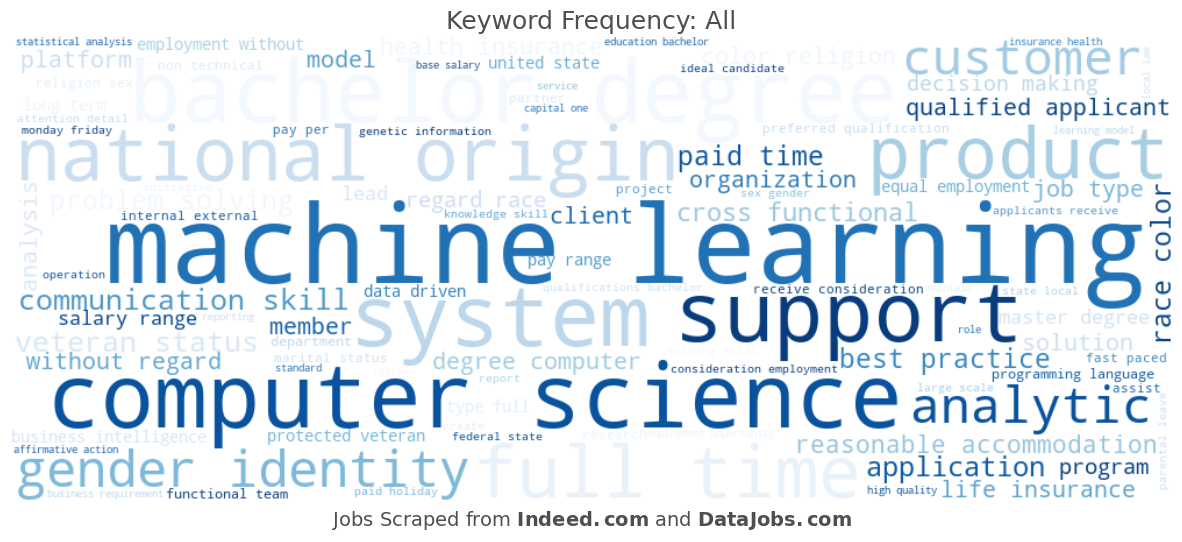

In [15]:
create_word_cloud(savefig=True)

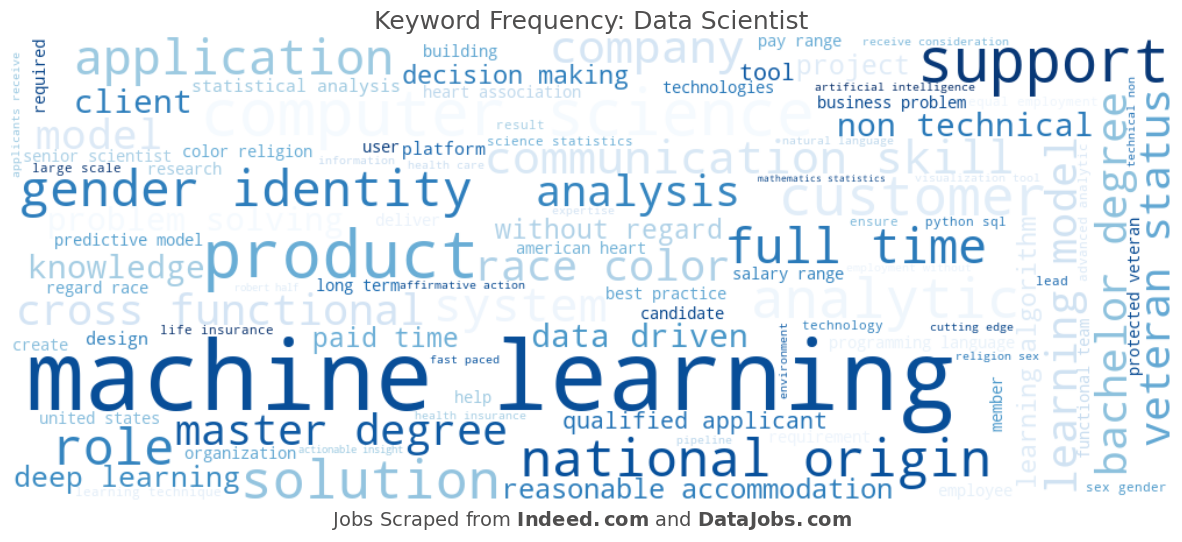

In [16]:
create_word_cloud(job_type='Data Scientist', savefig=True)

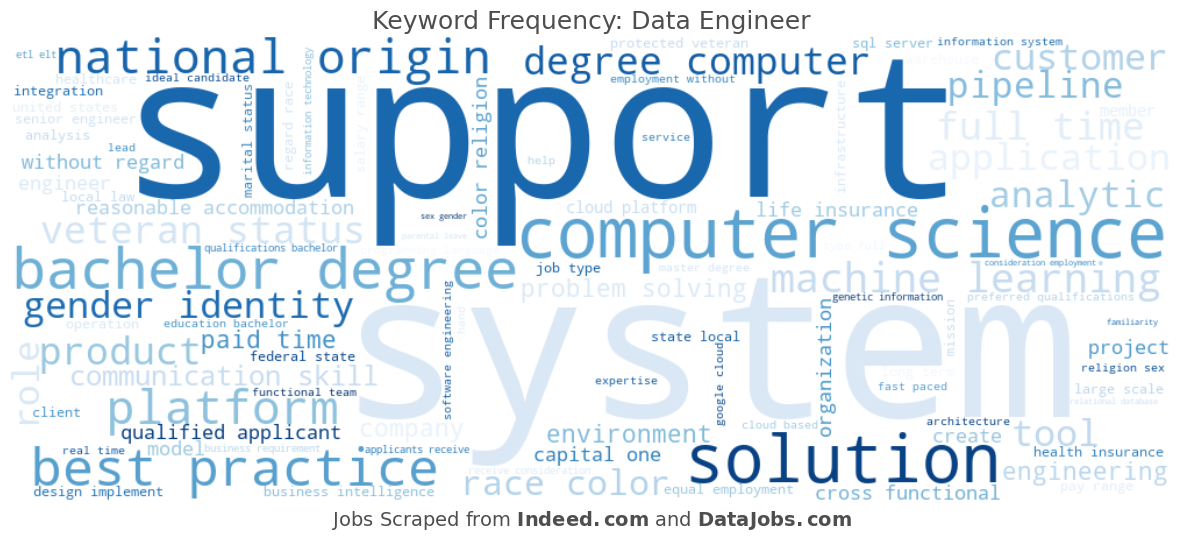

In [17]:
create_word_cloud(job_type='Data Engineer', savefig=True)

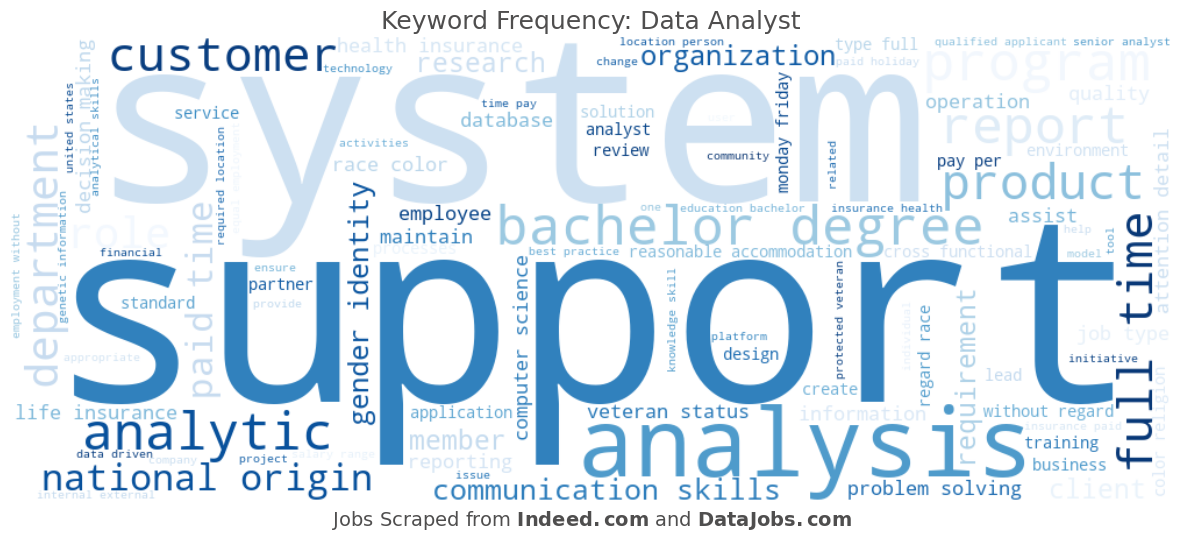

In [18]:
create_word_cloud(job_type='Data Analyst', savefig=True)

### A Better Word Cloud

These word clouds are pretty good. They can give us some nice general insight into these positions and what they might entail. For instance, I can see that there are some general data science buzz words popping up in these job postings like "Machine Learning" and "Visualization". However, these sorts of word clouds do not give us much insight into what tools and soft skills are required for these roles. Since I am looking to improve my marketability, I want to know what employers are looking for when hiring new candidates. A better way to accomplish this is to count the instances of *specific* words and phrases in these job descriptions. Then we can gather up these counts into a cleaner visualization that accounts for the type of word/phrase. First, let's define some lists of words we want to consider.

NOTE: I got some ideas from here: https://www.ischool.berkeley.edu/news/2019/word-clouds-we-cant-make-them-go-away-so-lets-improve-them

In [19]:
# NOTE: We aren't including Go as it is hard to distinguish it from the regular word.
# TODO: try to find that analyst influencers tool to add some stuff to this
job_descs_concat = job_descriptions['desc'].str.cat(sep=' ').lower()
# language_counts = {x:job_descs_concat.count(' ' + x.lower() + ' ') for x in programming_languages}
language_counts = kw_counter(text = job_descs_concat, kws = programming_languages)
library_counts = kw_counter(text = job_descs_concat, kws = libraries)
dev_tools_counts = kw_counter(text = job_descs_concat, kws = dev_tools + viz_tools)
databases_counts = kw_counter(text = job_descs_concat, kws = databases)
soft_skills_counts = kw_counter(text = job_descs_concat, kws = soft_skills)

Now that we have defined some keywords we want to search for, let's count them in our list of descriptions. Let's first visualize just using a static matplotlib visualizer...

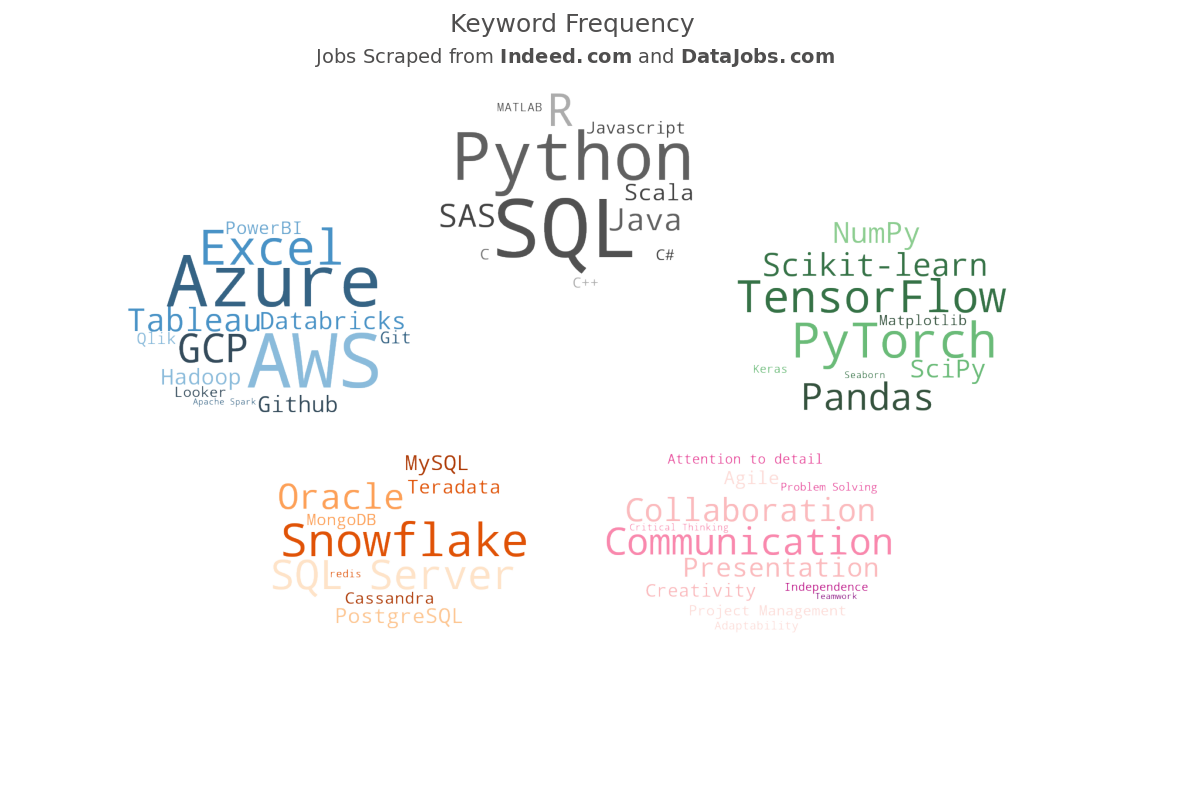

In [20]:
mask = np.array(Image.open("/home/colin/Pictures/ellipse.png"))

fig, ax = plt.subplots(figsize = (15,10))

ax.axis('off')

# you can play around with these parameters to adjust the positions and sizes of the sub-axes
main = 0.5
width = 0.30
offset = 0.20

wc_width = 1500
wc_height = 1000

upax = fig.add_axes([main - width/2, main + offset - width/2, width , width])

upax.set_title(f'Keyword Frequency', **title_kwargs);
plt.text(x=260, y=39, s='Jobs Scraped from $\\bf{Indeed.com}$ and $\\bf{DataJobs.com}$', **subtitle_kwargs)

# all of these calcs are to try to get a nice evenly spaced pentagon
uprightax = fig.add_axes([main + offset - width/2, main + 0.70*offset/2 - width/2, width , width])
upleftax = fig.add_axes([main - offset - width/2, main + 0.70*offset/2 - width/2, width , width])

downrightax = fig.add_axes([main + 0.60*offset - width/2, main - 0.75*offset - width/2, width , width])
downleftax = fig.add_axes([main - 0.60*offset - width/2, main - 0.75*offset - width/2, width , width])

# this is last to avoid overlapping issues
# midax = fig.add_axes([main - width/2, main - width/2, width , width])


wordcloud = WordCloud(background_color="rgba(255, 255, 255, 0)", 
                            mode="RGBA",
                          mask = mask,
                          max_words = 100, 
                          height = wc_height, 
                          width = wc_width, 
                          colormap=ListedColormap(sns.color_palette('Greys_d').as_hex()), 
                          min_word_length = 3,
                          prefer_horizontal=1,
                          min_font_size=18,
                          max_font_size=140).generate_from_frequencies(language_counts)


# Display the generated image:
upax.imshow(wordcloud, interpolation='bilinear')
upax.axis('off')


# library_counts = {x:job_descs_concat.count(' ' + x.lower() + ' ') for x in libraries}
wordcloud = WordCloud(background_color="rgba(255, 255, 255, 0)", 
                            mode="RGBA",
                          mask = mask,
                          max_words = 100, 
                          height = wc_height, 
                          width = wc_width, 
                          colormap=ListedColormap(sns.color_palette('Greens_d').as_hex()), 
                          min_word_length = 3,
                          prefer_horizontal=1,
                          min_font_size=14).generate_from_frequencies(library_counts)


# Display the generated image:
uprightax.imshow(wordcloud, interpolation='bilinear')
uprightax.axis('off')

# dev_tools_counts = {x:job_descs_concat.count(' ' + x.lower() + ' ') for x in dev_tools + viz_tools}
wordcloud = WordCloud(background_color="rgba(255, 255, 255, 0)", 
                            mode="RGBA",
                          mask = mask,
                          max_words = 100, 
                          height = wc_height, 
                          width = wc_width, 
                          colormap=ListedColormap(sns.color_palette('Blues_d').as_hex()), 
                          min_word_length = 3,
                          prefer_horizontal=1,
                          min_font_size=14).generate_from_frequencies(dev_tools_counts)


# Display the generated image:
upleftax.imshow(wordcloud, interpolation='bilinear')
upleftax.axis('off')


# databases_counts = {x:job_descs_concat.count(' ' + x.lower() + ' ') for x in databases}
wordcloud = WordCloud(background_color="rgba(255, 255, 255, 0)", 
                            mode="RGBA",
                          mask = mask,
                          max_words = 100, 
                          height = wc_height, 
                          width = wc_width, 
                          colormap=ListedColormap(sns.color_palette('Oranges').as_hex()), 
                          min_word_length = 3,
                          prefer_horizontal=1,
                          min_font_size=14).generate_from_frequencies(databases_counts)


# Display the generated image:
downleftax.imshow(wordcloud, interpolation='bilinear')
downleftax.axis('off')

# soft_skills_counts = {x:job_descs_concat.count(' ' + x.lower() + ' ') for x in soft_skills}
wordcloud = WordCloud(background_color="rgba(255, 255, 255, 0)", 
                            mode="RGBA",
                          mask = mask,
                          max_words = 100, 
                          height = wc_height, 
                          width = wc_width, 
                          colormap=ListedColormap(sns.color_palette('RdPu').as_hex()), 
                          min_word_length = 3,
                          prefer_horizontal=1,
                          min_font_size=14,
                          max_font_size=100).generate_from_frequencies(soft_skills_counts)


# Display the generated image:
downrightax.imshow(wordcloud, interpolation='bilinear')
downrightax.axis('off')

plt.savefig('FIGS/wc_specific.png');

In [21]:
df = job_meta[job_meta['clean_title'].isin([
    'Data Scientist',
    'Data Analyst',
    'Data Engineer'
])].melt(id_vars = ['clean_title', 'job_id', 'site'], value_vars = ['salary_lower', 'salary_upper'], var_name='Salary Type', value_name='Salary').sort_values(by=['job_id', 'site']).dropna(subset=['Salary'])

In [29]:
df.replace({'salary_lower': 'Salary Range (Lower)', 'salary_upper': 'Salary Range (Upper)'})

,clean_title,job_id,site,Salary Type,Salary
5094,Data Scientist,26,https://datajobs.com/,Salary Range (Lower),100000.0
10427,Data Scientist,26,https://datajobs.com/,Salary Range (Upper),150000.0
5100,Data Scientist,35,https://datajobs.com/,Salary Range (Lower),100000.0
10433,Data Scientist,35,https://datajobs.com/,Salary Range (Upper),150000.0
5106,Data Scientist,43,https://datajobs.com/,Salary Range (Lower),50000.0
...,...,...,...,...,...
10403,Data Engineer,9343,https://indeed.com/,Salary Range (Upper),104000.0
5071,Data Engineer,9344,https://indeed.com/,Salary Range (Lower),94300.0
10404,Data Engineer,9344,https://indeed.com/,Salary Range (Upper),182600.0
5072,Data Engineer,9345,https://indeed.com/,Salary Range (Lower),100000.0


/tmp/ipykernel_26324/2654380210.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels = labels);


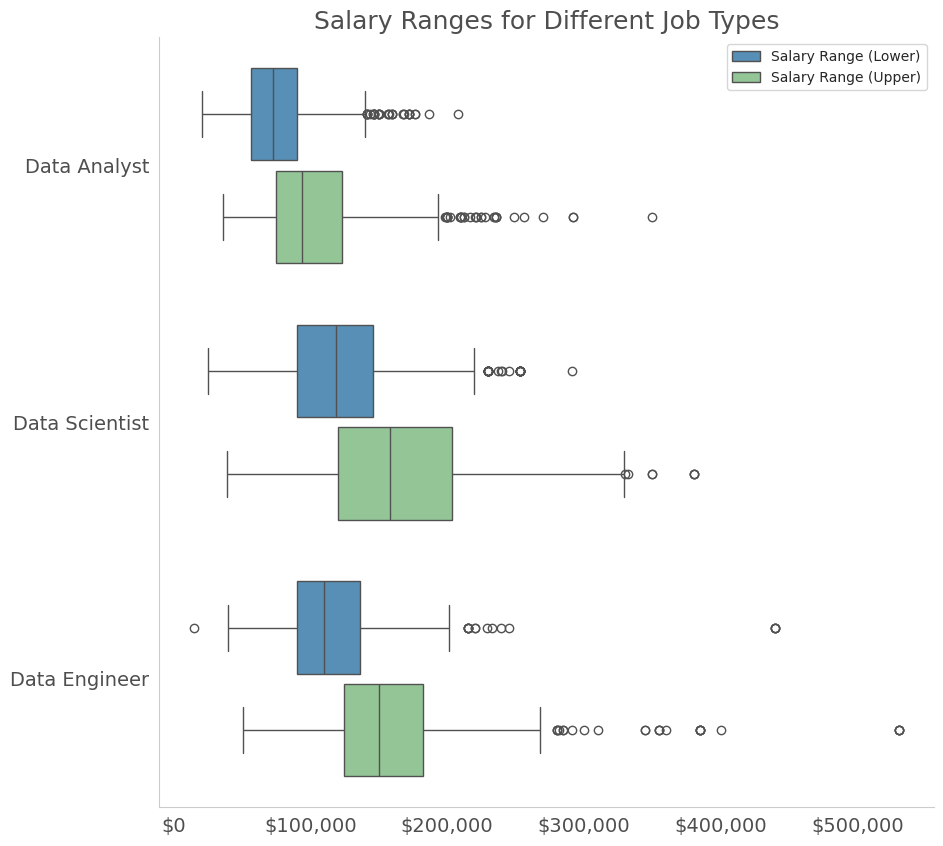

In [40]:
# I took a lot from here: https://github.com/mwaskom/seaborn/issues/720
fig, ax = plt.subplots(figsize = (10,10))

ax.set_title(f'Salary Ranges for Different Job Types', title_kwargs);
# plt.text(x=270_000, y=-0.44, s='Jobs Scraped from $\\bf{Indeed.com}$ and $\\bf{DataJobs.com}$', 
#                  color='#4f4e4e', fontsize=14, horizontalalignment='center')


bp_labels = ['Data Analyst Lower Salary', 'Data Analyst Upper Salary', 'Data Scientist Lower Salary', 'Data Scientist Upper Salary', 'Data Engineer Lower Salary', 'Data Engineer Upper Salary']
bp = sns.boxplot(data = df.replace({'salary_lower': 'Salary Range (Lower)', 'salary_upper': 'Salary Range (Upper)'}), y='clean_title', x='Salary', hue='Salary Type', ax=ax, orient='h', palette=[bl,gr], gap = 0.1, order = [
    'Data Analyst',
    'Data Scientist',
    'Data Engineer'
]);
sns.despine(top=True, right=True)

# ax.legend()
ax.grid(False)

ax.set_ylabel('');
ax.set_xlabel('');
plt.yticks(size=14, color=default_font_kwargs['color']);
plt.xticks(size=14, color=default_font_kwargs['color']);


plt.legend(loc='upper right')
# let's fix the x labels to be a little nicer to look at



labels = [item.get_text() for item in ax.get_xticklabels()]
for idx, label in enumerate(labels):
    if label[0] != "−":
        labels[idx] = f"${int(label):,}"

ax.set_xticklabels(labels = labels);

plt.savefig('FIGS/salaries.png');

In [33]:
labels

['−100000', '0', '100000', '200000', '300000', '400000', '500000', '600000']

In [23]:
job_meta[job_meta['salary_lower'] < 30_000]['url'].tolist()[2]

'https://www.indeed.com/viewjob?jk=55509048a398556f&bb=RUm-MTW8WESpEbET0-Tjsayof5b78C-W9O4N8w8Dktg-VF3q_qKEuh3_HUPjK2nq0agc6AlAbODZQqR2g0vsQjbQX2RWuzBiPJQKoxovx7erCTppgOGRPg%3D%3D&xkcb=SoAj67M3CgmOmPXvax0MbzkdCdPP&fccid=60c22b6df6415cc7&vjs=3'

In [24]:
sns.__version__

'0.13.2'